# Assignment 3

### Calculate the growth rate and volatility of the number of Netflix subscribers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

file_path = "C:\\Users\\10037\\Desktop\\Subscribers.xlsx"  #change file path when using
df = pd.read_excel(file_path)

# ensure the dates are in datetime format
df['DATES'] = pd.to_datetime(df['DATES'])
df['Dates'] = pd.to_datetime(df['Dates'])

# extract the year from the 'DATES' column
df['Year'] = df['DATES'].dt.year

# group by year and get the end-of-year subscriber count
end_of_year_subscribers = df.groupby('Year')['Subscribers'].last().reset_index()

# calculate the yearly growth rates
end_of_year_subscribers['Growth_Rate'] = end_of_year_subscribers['Subscribers'].pct_change()

# Drop the first row (no growth rate for the first year)
end_of_year_subscribers = end_of_year_subscribers.dropna()

# calculate the mean growth rate
mean_growth_rate = end_of_year_subscribers['Growth_Rate'].mean()

# calculate the volatility (standard deviation of growth rates)
volatility = end_of_year_subscribers['Growth_Rate'].std()

# Print the results
print(f"Annual Mean Growth Rate: {mean_growth_rate:.2%}")
print(f"Volatility of Subscriber Growth: {volatility:.2%}")

Annual Mean Growth Rate: 3.58%
Volatility of Subscriber Growth: 3.36%


### Data Processing

Data Preview:
       DATES   Subscribers  Unnamed: 2      Dates   Price
0 2022-01-27  2.762025e+08         NaN 2022-01-27  386.70
1 2022-03-08  2.762025e+08         NaN 2022-01-28  384.36
2 2022-04-13  2.762025e+08         NaN 2022-01-31  427.14
3 2022-04-20  2.622780e+08         NaN 2022-02-01  457.13
4 2022-04-21  2.600598e+08         NaN 2022-02-02  429.48


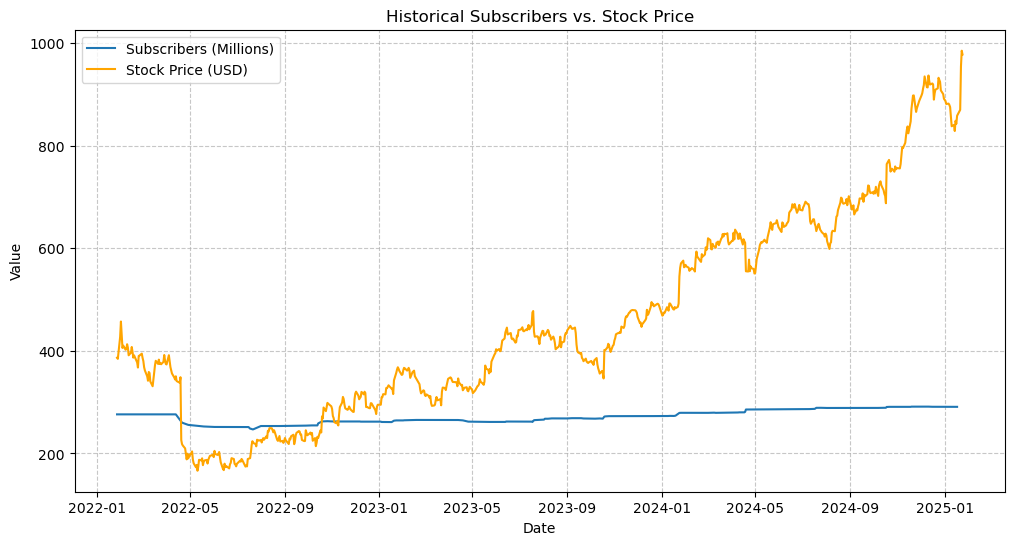

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

file_path = "C:\\Users\\10037\\Desktop\\Subscribers.xlsx"  #change file path when using
data = pd.read_excel(file_path)
print("Data Preview:")
print(data.head())

# Convert dates to datetime
data['DATES'] = pd.to_datetime(data['DATES'])
data['Dates'] = pd.to_datetime(data['Dates'])

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(data['DATES'], data['Subscribers']/1e6, label='Subscribers (Millions)')
plt.plot(data['Dates'], data['Price'], label='Stock Price (USD)', color='orange')
plt.title('Historical Subscribers vs. Stock Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

### Linear Regression

In [26]:
# Align data by date
merged_data = pd.merge(
    data[['DATES', 'Subscribers']], 
    data[['Dates', 'Price']], 
    left_on='DATES', 
    right_on='Dates', 
    how='inner'
)

# Normalize subscribers to millions
X = merged_data['Subscribers'].values.reshape(-1, 1) / 1e6  # X in millions
y = merged_data['Price'].values

# Train model
model = LinearRegression()
model.fit(X, y)
alpha = model.intercept_
beta = model.coef_[0]

print("\nRegression Results:")
print(f"Stock Price = {alpha:.2f} + {beta:.2f} * (Subscribers in Millions)")
print(f"R² Score: {model.score(X, y):.4f}")

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from sklearn.utils import resample

# For statsmodels summary
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()

print("\n[Regression Summary]")
print(model_sm.summary())

# Residual diagnostics
residuals = model_sm.resid
print("\n[Residual Diagnostics]")
print(f"Durbin-Watson Statistic: {sm.stats.stattools.durbin_watson(residuals):.2f}")


Regression Results:
Stock Price = -3537.50 + 14.76 * (Subscribers in Millions)
R² Score: 0.8888

[Regression Summary]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1206.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           6.75e-74
Time:                        22:52:54   Log-Likelihood:                -856.46
No. Observations:                 153   AIC:                             1717.
Df Residuals:                     151   BIC:                             1723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

### Monte Carlo Simulation

In [4]:
from sklearn.utils import resample

# Bootstrap to estimate coefficient uncertainty
n_bootstraps = 1000
boot_alphas = []
boot_betas = []

for _ in range(n_bootstraps):
    X_boot, y_boot = resample(X, y)  # Resample with replacement
    model_boot = LinearRegression().fit(X_boot, y_boot)
    boot_alphas.append(model_boot.intercept_)
    boot_betas.append(model_boot.coef_[0])

# Now use boot_alphas and boot_betas in Monte Carlo simulations

In [6]:
# Simulate future subscribers 
current_subscribers = merged_data['Subscribers'].iloc[-1]  # Raw count
mean_growth = 0.0358    # 3.58% annual growth
volatility = 0.0336     # 3.36% volatility
years = 5               # Forecast horizon
n_sims = 1000           # Number of simulations

current_subscribers = merged_data['Subscribers'].iloc[-1]
subscriber_paths = np.zeros((years + 1, n_sims))
subscriber_paths[0] = current_subscribers

dt = 1
for t in range(1, years + 1):
    drift = (mean_growth - 0.5 * volatility**2) * dt
    shock = volatility * np.random.normal(0, 1, n_sims) * np.sqrt(dt)
    subscriber_paths[t] = subscriber_paths[t-1] * np.exp(drift + shock)

In [7]:
# Simulate prices with regression uncertainty and residuals
price_paths = np.zeros((years + 1, n_sims))
residuals = y - model.predict(X)

for sim in range(n_sims):
    # Randomly sample coefficients and residual
    idx = np.random.randint(n_bootstraps)
    alpha_sim = boot_alphas[idx]
    beta_sim = boot_betas[idx]
    residual_sim = np.random.choice(residuals)
    
    for t in range(years + 1):
        # Predict price using sampled coefficients and residual
        price_paths[t, sim] = (
            alpha_sim + 
            beta_sim * (subscriber_paths[t, sim] / 1e6) + 
            residual_sim
        )

In [8]:

final_prices = price_paths[-1]
mean_price = np.mean(final_prices)
ci_95 = np.percentile(final_prices, [2.5, 97.5])

print("\nForecast Results:")
print(f"Mean Predicted Price ({years} years): ${mean_price:.2f}")
print(f"95% Confidence Interval: [${ci_95[0]:.2f}, ${ci_95[1]:.2f}]")



Forecast Results:
Mean Predicted Price (5 years): $1575.15
95% Confidence Interval: [$877.34, $2354.53]


Text(0, 0.5, 'Price (USD)')

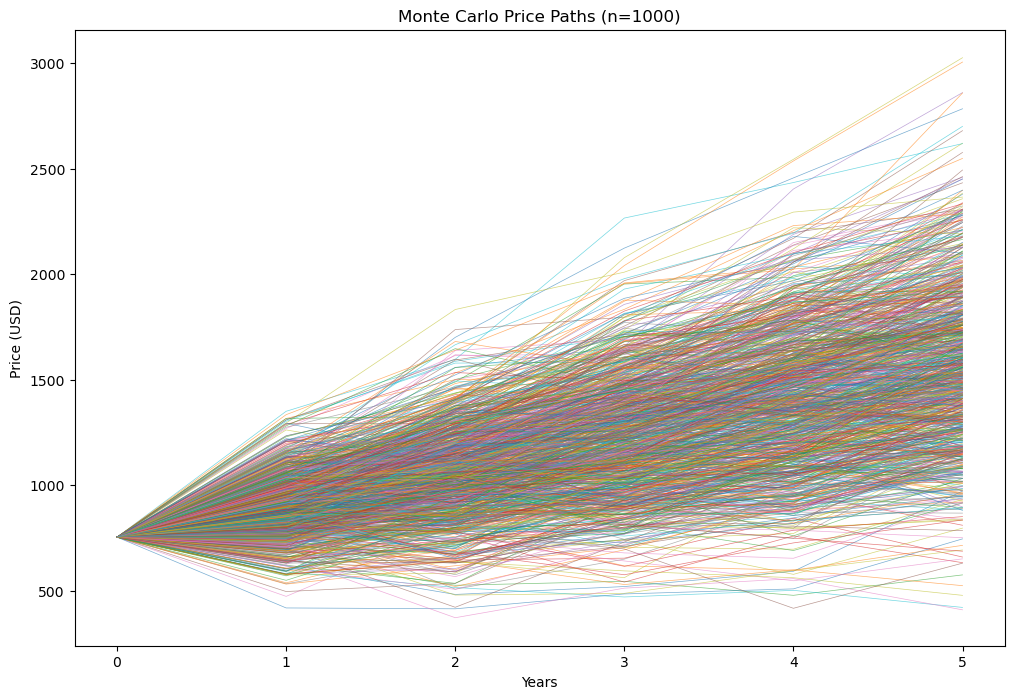

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(price_paths, linewidth=0.5, alpha=0.6)
plt.title(f'Monte Carlo Price Paths (n={n_sims})')
plt.xlabel('Years')
plt.ylabel('Price (USD)')


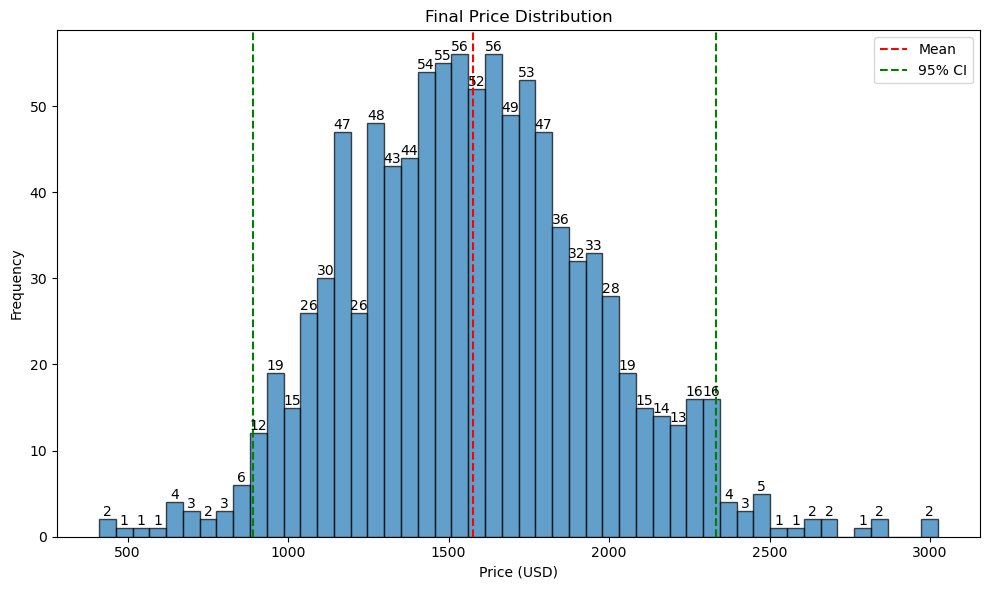

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=50, edgecolor='k', alpha=0.7)
# Label each histogram bar with its count
for i in range(len(patches)):
    bin_center = (bins[i] + bins[i+1]) / 2
    bin_height = n[i]
    if bin_height > 0:  # Avoid labeling empty bars
        plt.text(
            x=bin_center, 
            y=bin_height, 
            s=f'{int(bin_height)}', 
            ha='center', 
            va='bottom',
            fontsize=10,
            rotation=0)
plt.axvline(mean_price, color='red', linestyle='--', label='Mean')
plt.axvline(ci_95[0], color='green', linestyle='--', label='95% CI')
plt.axvline(ci_95[1], color='green', linestyle='--')
plt.title('Final Price Distribution')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()